In [1]:
from __future__ import print_function
from PIL import Image
import os
import os.path
import errno
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity


class Semeion(data.Dataset):
    """`SEMEION <http://archive.ics.uci.edu/ml/datasets/semeion+handwritten+digit>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directory
            ``semeion.py`` exists.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    url = "http://archive.ics.uci.edu/ml/machine-learning-databases/semeion/semeion.data"
    filename = "semeion.data"
    md5_checksum = 'cb545d371d2ce14ec121470795a77432'

    def __init__(self, root, transform=None, target_transform=None, download=True):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        self.data = []
        self.labels = []
        fp = os.path.join(root, self.filename)
        data = np.loadtxt(fp)
        # convert value to 8 bit unsigned integer
        # color (white #255) the pixels
        self.data = (data[:, :256] * 255).astype('uint8')
        self.data = np.reshape(self.data, (-1, 16, 16))
        self.labels = data[:, 256:]

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.labels[index]
    
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img, mode='L')
    
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img, target

    def __len__(self):
        return len(self.data)

    def _check_integrity(self):
        root = self.root
        fpath = os.path.join(root, self.filename)
        if not check_integrity(fpath, self.md5_checksum):
            return False
        return True

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        root = self.root
        download_url(self.url, root, self.filename, self.md5_checksum)

In [2]:
import torch
import random

class SubsetSampler(object):

    def __init__(self, subset):
        self.subset = subset

    def __iter__(self):
        return iter(self.subset)

    def __len__(self):
        return len(self.subset)


class SemeionSampler(object):

    def __init__(self, data_source, train_share=0.8):

        # Generate a list of indizes reaching from 0 ... len(data_source)-1
        idxList = list(range(0,len(data_source)))

        # Ensure that list is sorted randomly
        random.shuffle(idxList)

        # Split dataset random shares of train and test data
        numberOfTrainSamples = int(len(data_source) / (1 / train_share))
        
        self.train_samples = idxList[:numberOfTrainSamples]
        self.test_samples = idxList[numberOfTrainSamples:]


    def trainSampler(self):
        return SubsetSampler(self.train_samples)

    def testSampler(self):
        return SubsetSampler(self.test_samples)

In [3]:
import numpy as np
import torch

# Converts the 1-channel image into a 3-channel mage
class ExpandTo3D(object):

    def __call__(self, image):

        width = image.size()[1]
        height = image.size()[2]

        return image.expand(3,width,height)


# Transform 10-dimensional label data into 1-dimension
# Example: 0 0 1 0 0 0 0 0 0 0 => 2
class TransformLabel(object):

    def __call__(self, label):

        idx = np.where(label==1)[0][0]

        return idx


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):

        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(20, 60, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(60 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 60 * 7 * 7)
        x = self.classifier(x)
        return x

In [5]:
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torchvision.datasets
import torchvision.models as models


transformsData = transforms.Compose([transforms.ToTensor()] )
transformsTarget = transforms.Compose([TransformLabel()])

dataset = Semeion(root='./data', download=True, transform=transformsData, target_transform=transformsTarget)

sampler = SemeionSampler(dataset)

trainloader = torch.utils.data.DataLoader(dataset, batch_size=20, sampler=sampler.trainSampler(), num_workers=2 )
testloader = torch.utils.data.DataLoader(dataset, batch_size=20, sampler=sampler.testSampler(), num_workers=2)

net = Net()
net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print("Start training")
for epoch in range(200):
    
    running_loss = 0.0
    for data in trainloader:
        
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    print(loss.data[0])

    correct = 0
    total = 0
    
    for data in testloader:
  
        images, labels = data
        outputs = net(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()
        
    print('Accuracy of the network on the test images: %f %%' % (100 * correct / total))

print('Finished Training')


Files already downloaded and verified
Start training
2.272585153579712
Accuracy of the network on the test images: 14.106583 %
2.2426493167877197
Accuracy of the network on the test images: 15.987461 %
2.198925256729126
Accuracy of the network on the test images: 20.062696 %
2.1262919902801514
Accuracy of the network on the test images: 35.736677 %
1.846825361251831
Accuracy of the network on the test images: 46.394984 %
1.403351902961731
Accuracy of the network on the test images: 51.410658 %
0.9711580276489258
Accuracy of the network on the test images: 67.084639 %
0.6470972299575806
Accuracy of the network on the test images: 70.846395 %
0.6908352971076965
Accuracy of the network on the test images: 73.354232 %
0.2538108229637146
Accuracy of the network on the test images: 74.921630 %
0.271645188331604
Accuracy of the network on the test images: 78.996865 %
0.5769652128219604
Accuracy of the network on the test images: 77.429467 %
0.22844569385051727
Accuracy of the network on the t

0.005326475482434034
Accuracy of the network on the test images: 96.551724 %
0.0004349436203483492
Accuracy of the network on the test images: 95.924765 %
0.0018377985106781125
Accuracy of the network on the test images: 96.238245 %
0.00032070704037323594
Accuracy of the network on the test images: 96.551724 %
0.00015177045133896172
Accuracy of the network on the test images: 96.865204 %
0.0007798331207595766
Accuracy of the network on the test images: 96.865204 %
0.00022384097974281758
Accuracy of the network on the test images: 97.178683 %
0.0014008113648742437
Accuracy of the network on the test images: 96.865204 %
0.0008808544953353703
Accuracy of the network on the test images: 96.238245 %
0.0004049709823448211
Accuracy of the network on the test images: 97.178683 %
0.010068212635815144
Accuracy of the network on the test images: 95.924765 %
0.02323872782289982
Accuracy of the network on the test images: 96.865204 %
0.002084186999127269
Accuracy of the network on the test images: 

Process Process-565:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-566:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, i

KeyboardInterrupt: 

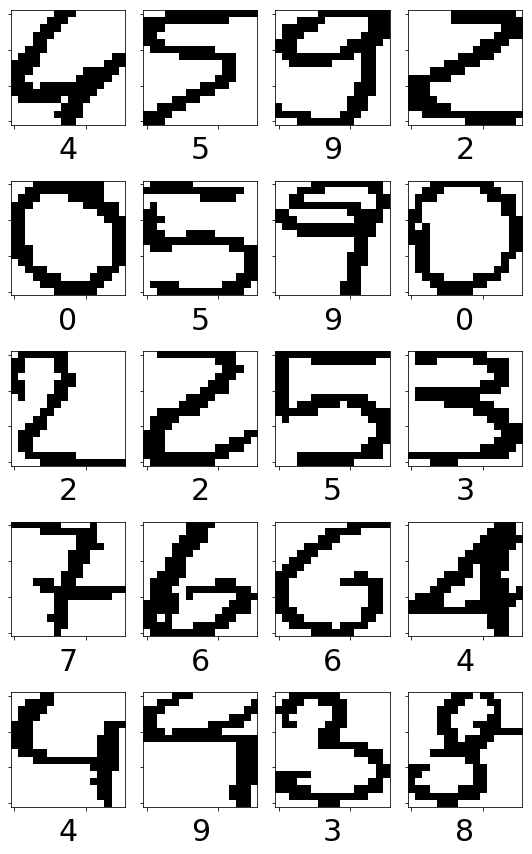

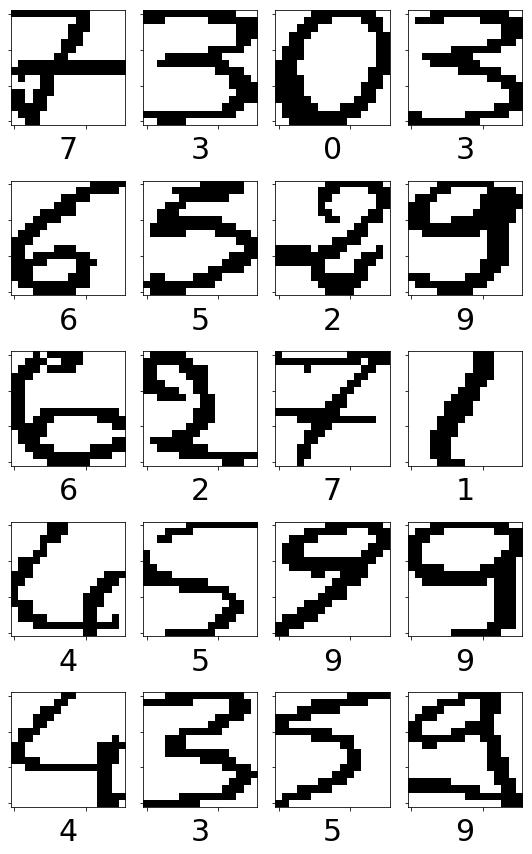

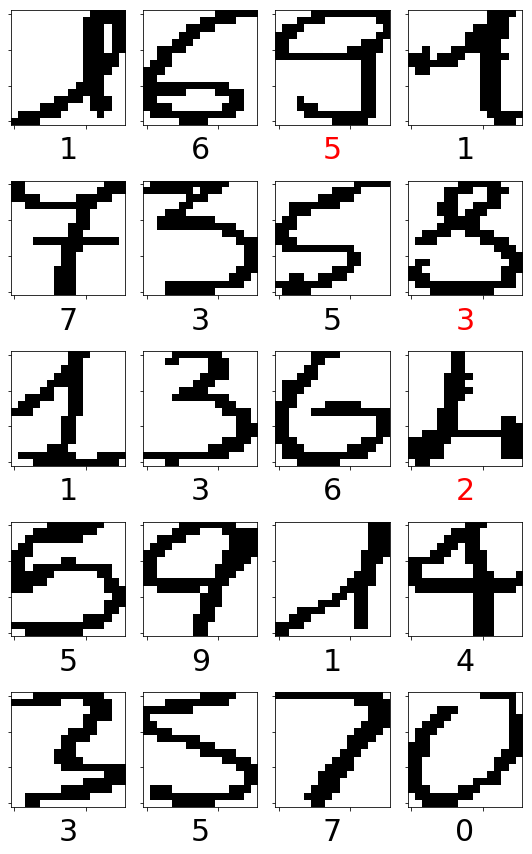

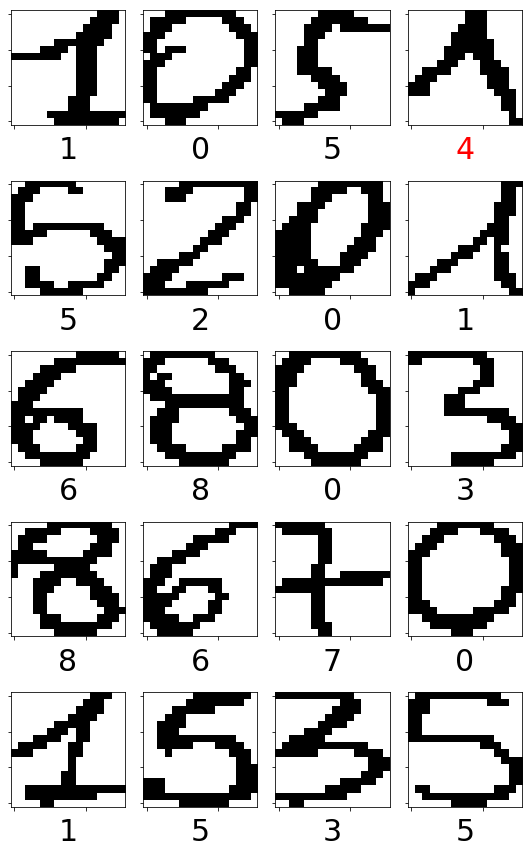

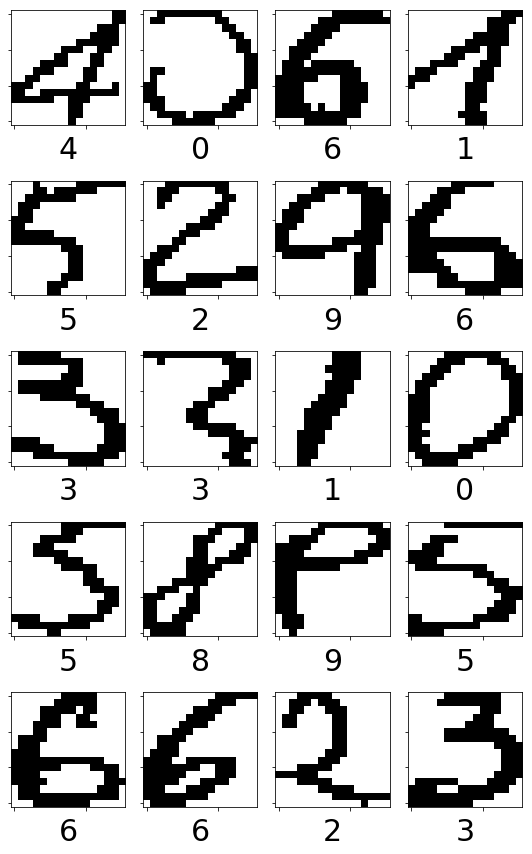

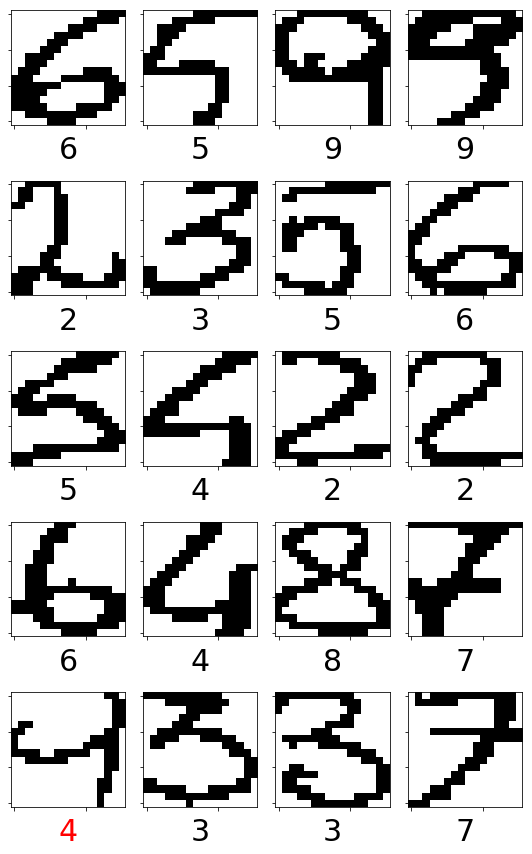

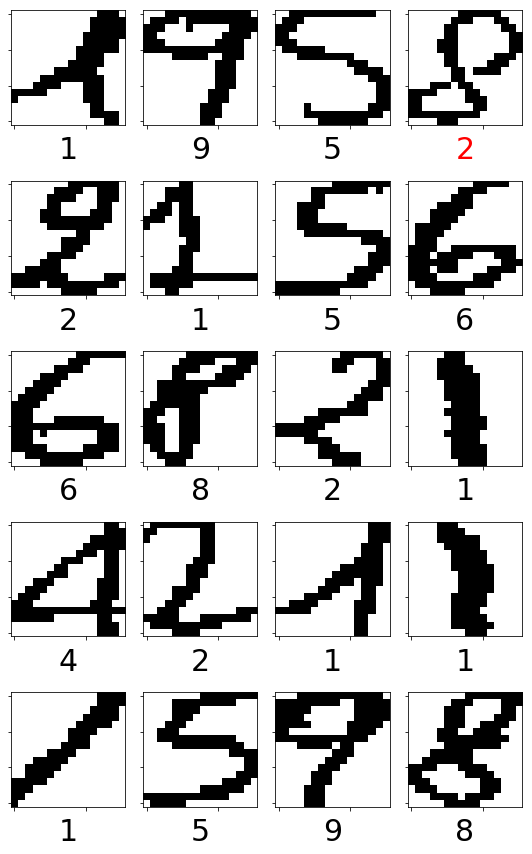

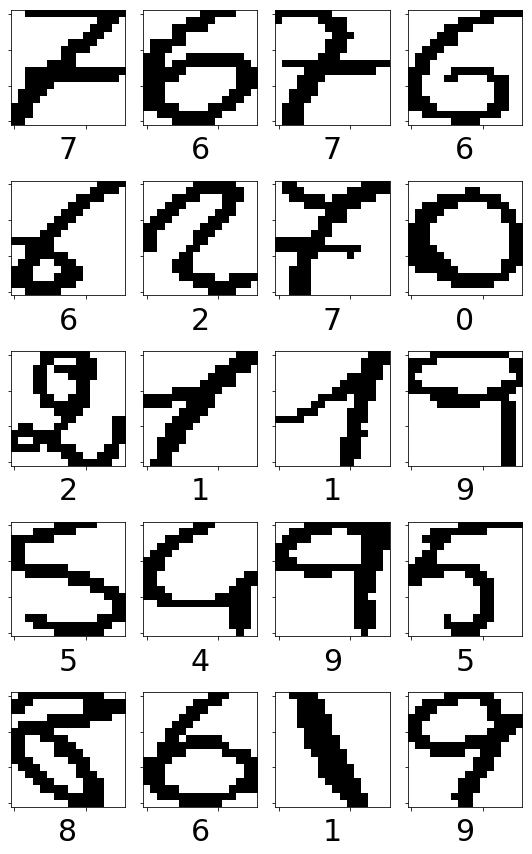

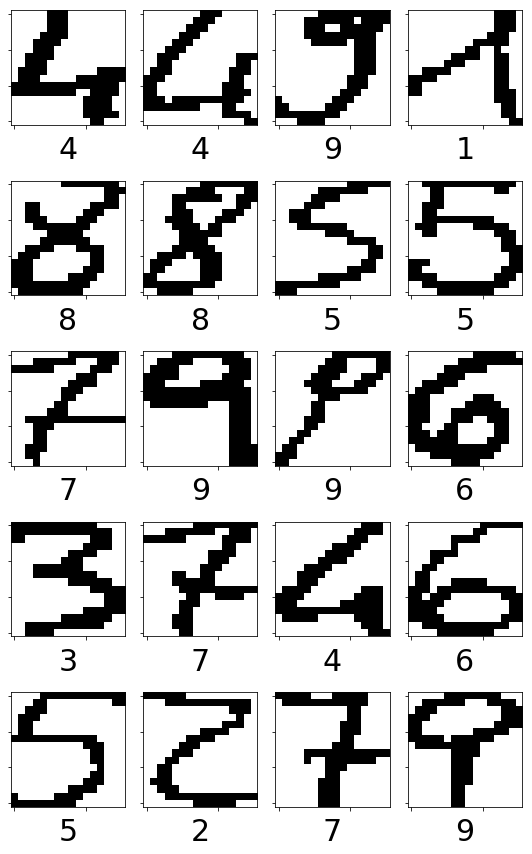

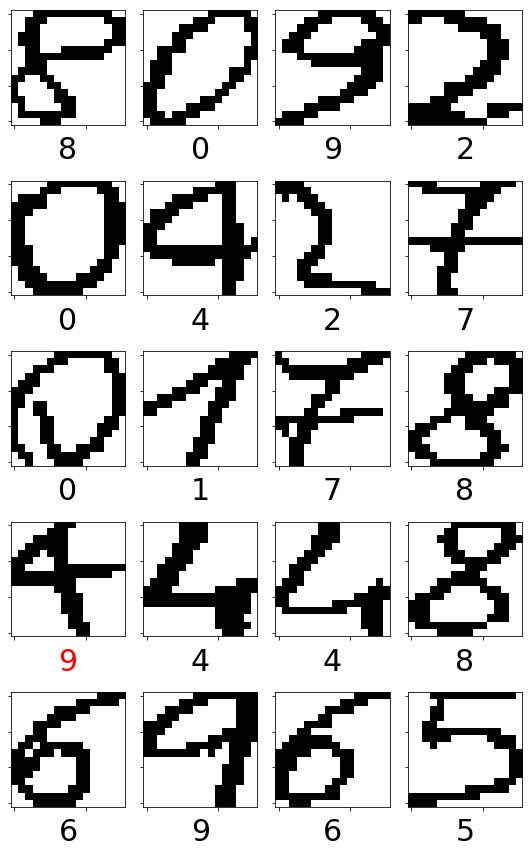

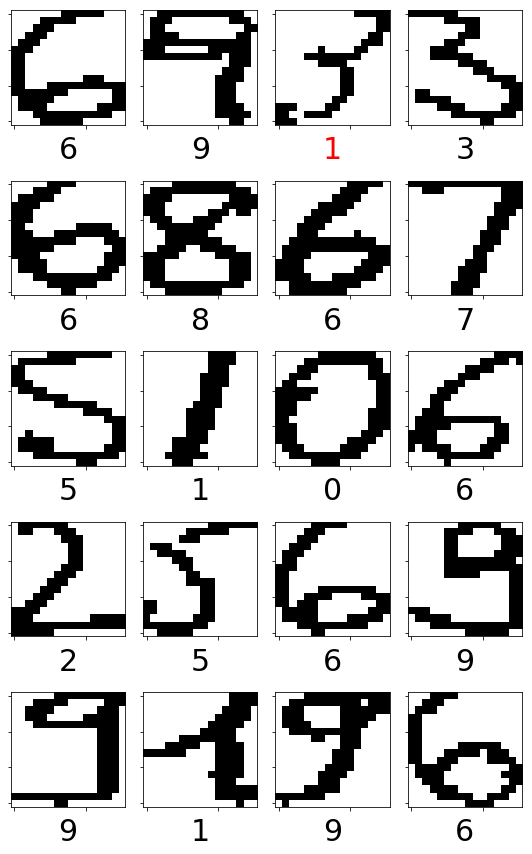

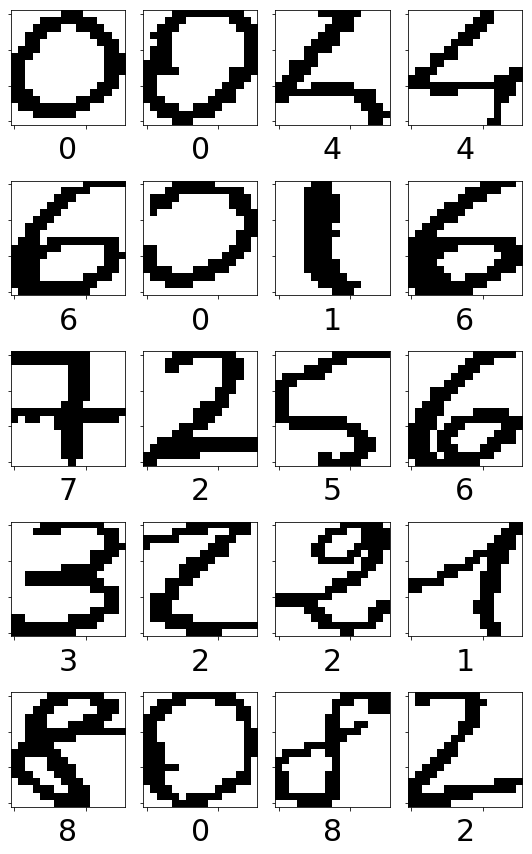

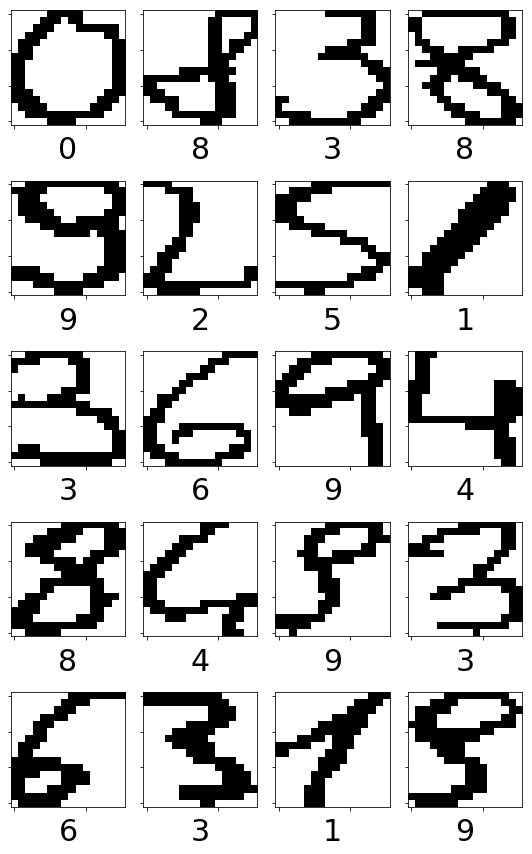

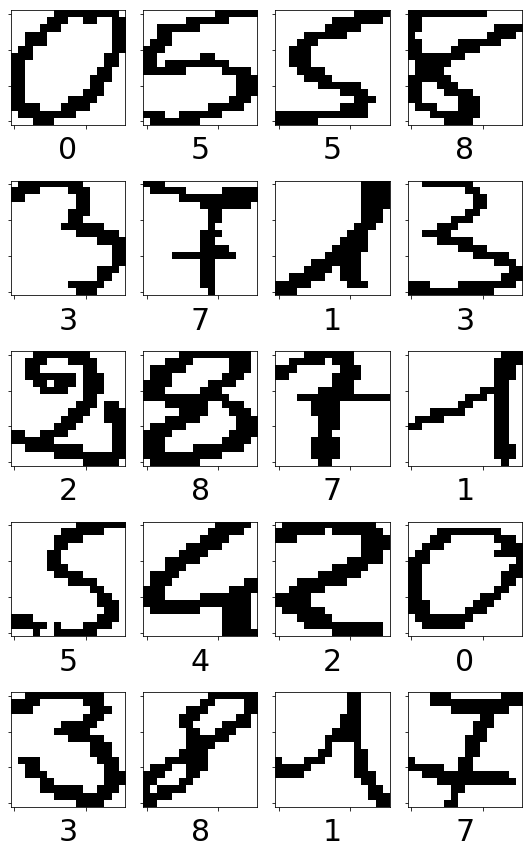

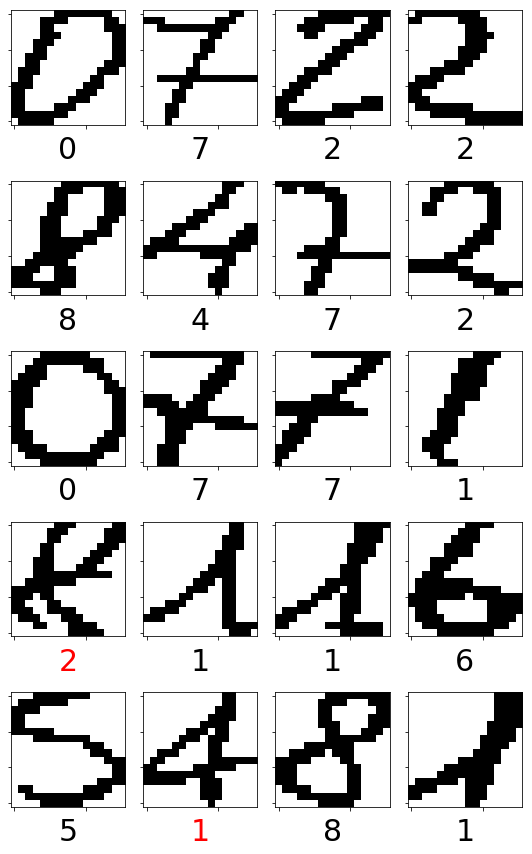

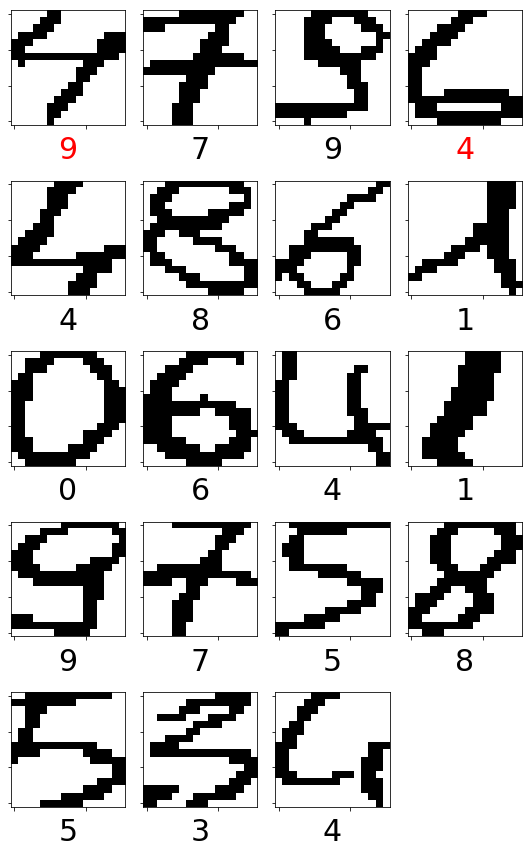

In [6]:
import matplotlib.pyplot as plt

def showFloatImages(image,prediction, real_label):
    
    for i,img3channel in enumerate(image.numpy()):

        img1channel = img3channel[0]
        
        plt.tight_layout( rect=[0.5, 0, 3, 3], h_pad=1)
        
        subplot = plt.subplot(5,4,i+1)

        if prediction[i] == real_label[i]:
            subplot.xaxis.label.set_color('black')
        else:
            subplot.xaxis.label.set_color('red')
            
        subplot.set_xlabel(str(prediction[i])).set_fontsize(30)
        subplot.set_yticklabels([])
        subplot.set_xticklabels([])
        
        plt.imshow(img1channel, cmap='Greys')
        
    
    plt.pause(1)


# Visualize results
for data in testloader:

    images, labels = data

    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    plt.figure(figsize=(3,4))
    showFloatImages(images, predicted, labels)

